<a href="https://colab.research.google.com/github/DrAlexSanz/Emojify/blob/master/Emojify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd "/content"
!rm -rf Emojify

!git clone https://github.com/DrAlexSanz/Emojify.git
  
%cd "/content/Emojify"

/content
Cloning into 'Emojify'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 34 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (34/34), done.
/content/Emojify


In [2]:
!pip install emoji
import numpy as np
import emoji
from emo_utils import *
import matplotlib.pyplot as plt

     |████████████████████████████████| 51kB 3.4MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42175 sha256=1a979d5c3ce567d1ad6edd0957e7aac450008e448bb5e9037c787b254de77cca
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [0]:
X_train, y_train = read_csv("Data/train_emoji.csv")
X_test, y_test = read_csv("Data/tesss.csv")

Now I have all the data read, train and test.

In [4]:
index = 13

print(X_train[index], label_to_emoji(y_train[index]))

my algorithm performs poorly 😞


This is a bit pessimistic. At least I'm not, but if you are, change the index and find a nicer one.

Since the labels are numerical, 0, 1, 2, etc. I have to convert them to one-hot encoding. I just happen to have a function for this. How convenient and how elegant.

In [0]:
Y_oh_train = convert_to_one_hot(y_train, C = 5)
Y_oh_test = convert_to_one_hot(y_test, C = 5)

In [6]:
# To test
index = 13
print(str(y_train[index]) + " converted to one-hot is " + str(Y_oh_train[index]))

3 converted to one-hot is [0. 0. 0. 1. 0.]


Now one thing I should do is to read the GloVe vectors. I have them somewhere in google drive.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs("/content/drive/My Drive/Glove/glove.6B.50d.txt")

As a reminder:


*   word to index is a dictionary mapping, from word to the indices of the vocabulary.
*   index to word is the inverse mapping.
*   word to vec is the mapping of word towards vector.

If I want an index to vec mapping I need ot do it in two steps, but just that.



In [9]:
#Check this. Words are uncased!!

word = "cucumber"
index =325651

print("The index of " + word + " is: " + str(word_to_index[word]))
print("The word for index " + str(index) + " is " + str(index_to_word[index]))

The index of cucumber is: 113317
The word for index 325651 is serpent


Implement sentence to average. Take a sentence, split it and get the average of the 50D encoding. This will be useful later.

In [0]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    The function takes a sentence, makes it lowercase and split it and then convert the words to the vector repesentation
    Then the vectors are averaged
    
    Inputs: Sentence (string) and word_to_vec mapping
    
    Output: The average of the vector encoding    
    """
    
    # Split and lowercase
    
    words = [i.lower() for i in sentence.split()]
    
    #Initialize average
    avg = np.zeros((50,))
    
    for w in words:
        avg = avg + word_to_vec_map[w]
    
    avg = avg / len(words)
    
    return avg

In [11]:
cipote = sentence_to_avg("I am freezing my balls off", word_to_vec_map)
print(cipote)

[-0.051069    0.12433     0.081878   -0.5130015   0.29943    -0.26324583
 -0.23595083  0.425795   -0.2300275   0.0600616  -0.323376    0.24681933
 -0.52268167  0.24817317  0.56375333  0.35045883  0.0247455   0.06972833
 -0.56337367 -0.508585   -0.049363    0.75631733  0.83157167  0.01987943
  0.70788167 -1.47618815 -0.19596167  0.57402167  0.99243833 -0.41436
  2.91251667  0.53820067 -0.328577    0.65779    -0.08201983 -0.11146383
  0.37991033  0.29880333  0.40358167 -0.09752667 -0.10254905 -0.03126967
  0.06808833  0.55769467  0.038393    0.17677167 -0.061905   -0.42140067
  0.04015717  0.10534333]


So with this function, I'll take the average output and do the forward/ backward cycle. I use the cross-entropy as the loss and the y predicted is assumed to be the one-hot encoding of the labels.

$$ z^{(i)} = W . avg^{(i)} + b$$$$ a^{(i)} = softmax(z^{(i)})$$$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Yoh^{(i)}_k * log(a^{(i)}_k)$$

In [0]:
def model(X, Y, word_to_vec_map, learning_rate, num_iterations):
    """
    This function trains the model itself.
    
    inputs. X, Y are the data + labels, (m, 1) in shape and Y is NOT the One-Hot encoding. Other inputs are self explanatory.
    
    Output: pred is the vector of predictions, (m, 1)
            W is the weight matrix of the softmax layer (last one). Shape (n_y, n_h)
            b is the bias of the softmax layer. Shape (n_y,)
    """
    
    np.random.seed(1)
    
    # Get shapes
    
    m = Y.shape[0]
    n_y = 5 # Classes!!
    n_h = 50 # This is from the glove vectors.
    
    # Initialize W, b using Xavier initialization. Manually because I can.
    
    W = np.random.randn(n_y, n_h)/np.sqrt(n_h)
    b = np.random.randn(n_y,)
    
    # Convert to one hot.
    
    Y_oh = convert_to_one_hot(Y, C = n_y)
    
    # The optimization loop. Loop over every example and then do it for n iterations.
    
    for iter in range(num_iterations):
        for i in range(m):
            
            # Get average for input
            avg = sentence_to_avg(X[i], word_to_vec_map)
            
            # Forward prop. Check the equations above.
            z = np.dot(W, avg) + b
            a = softmax(z)
            
            # Compute cost
            cost = -np.sum(np.multiply(Y_oh[i], np.log(a)))
            
            # Gradients! Check it by hand because this is not obvious.
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y, 1), avg.reshape(1, n_h))
            db = dz
            
            # Update
            W = W - learning_rate * dW
            b = b - learning_rate * db
            
            # Print some of them
            
        if iter % 100 == 0:
            print("At iteration " + str(iter) + " the cost is " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [13]:
learn = 0.01
num_iter = 400

pred, W, b = model(X_train, y_train, word_to_vec_map, learn, num_iter)
# print(pred)

At iteration 0 the cost is 2.1300543103075373
Accuracy: 0.3106060606060606
At iteration 100 the cost is 0.09053564064959209
Accuracy: 0.9318181818181818
At iteration 200 the cost is 0.049156948876741956
Accuracy: 0.946969696969697
At iteration 300 the cost is 0.03715457018186422
Accuracy: 0.9696969696969697


So around 96 % accuracy on the train set, let's check the test set accuracy.

In [14]:
print("Train set prediction:")
pred_train = predict(X_train, y_train, W, b, word_to_vec_map)
# print(pred_train)

print("Test set prediction:")
pred_test = predict(X_test, y_test, W, b, word_to_vec_map)
# print(pred_test)

Train set prediction:
Accuracy: 0.9772727272727273
Test set prediction:
Accuracy: 0.8571428571428571


Not too bad! From 97% to almost 86% test set accuracy. For a tiny dataset this is very good. Last check.

In [15]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels, W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄


Because adore has a similar embedding as love, the algorithm has generalized correctly even to a word it has never seen before. Words such as heart, dear, beloved or adore have embedding vectors similar to love, and so might work too. However the not feeling happy doesn't work well. It doesn't remember the not because the model only averages words, it doesn't understand the combinations. Not surprising, but still impressive for such a simple model.
To avoid this problem let's try a LSTM.

In [0]:
np.random.seed(1)

from keras.models import Model
from keras.utils import plot_model
from keras.layers import LSTM, Dense, Input, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

from keras.callbacks import History
from keras import optimizers


Most deep learning frameworks require that all sequences in the same mini-batch have the same length. This is what allows vectorization to work: If you had a 3-word sentence and a 4-word sentence, then the computations needed for them are different (one takes 3 steps of an LSTM, one takes 4 steps) so it's just not possible to do them both at the same time.

The common solution to this is to use padding. Specifically, set a maximum sequence length, and pad all sequences to the same length. For example, of the maximum sequence length is 20, we could pad every sentence with "0"s at the end so that each input sentence is of length 20. Thus, a sentence "i love you" would be represented as $(e_{i}, e_{love}, e_{you}, \vec{0}, \vec{0}, \ldots, \vec{0})$. In this example, any sentences longer than 20 words would have to be truncated. One simple way to choose the maximum sequence length is to just pick the length of the longest sentence in the training set.

## The Embedding layer
In Keras, the embedding matrix is represented as a "layer", and maps positive integers (indices corresponding to words) into dense vectors of fixed size (the embedding vectors). It can be trained or initialized with a pretrained embedding. In this part, you will learn how to create an Embedding() layer in Keras, initialize it with the GloVe 50-dimensional vectors loaded earlier in the notebook. Because our training set is quite small, we will not update the word embeddings but will instead leave their values fixed. But in the code below, we'll show you how Keras allows you to either train or leave fixed this layer.

The Embedding() layer takes an integer matrix of size (batch size, max input length) as input. This corresponds to sentences converted into lists of indices (integers), as shown in the figure below.

The largest integer (i.e. word index) in the input should be no larger than the vocabulary size. The layer outputs an array of shape (batch size, max input length, dimension of word vectors).

The first step is to convert all the training sentences into lists of indices, and then zero-pad all these lists so that their length is the length of the longest sentence.

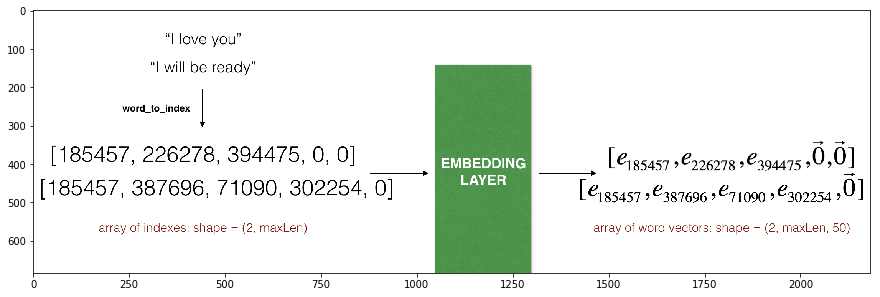

In [17]:
embedding1 = plt.imread("embedding1.png")
plt.figure(figsize = (15, 10))
plt.imshow(embedding1)

In [0]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    This function takes a batch of sentences (strings), does the lower() and strip() and then converts the sentence to indices
    
    Inputs: X are the m phrases in string format.
            word_to_index is the mapping
            max len is the maximum length of a phrase found in X, for the padding
            
    Outputs: a batch of indices (X_indices), shape is (m, max_len)    
    """
    
    m = X.shape[0]
    
    X_indices = np.zeros((m, max_len)) # The zeroes of the shorter sentences won't be changed.
    
    for i in range(m):
        sentence_words = [w.lower() for w in X[i].split()]
        
        j = 0 # For the columns, i was for the rows. Don't lose track of this.
        
        for w in sentence_words:
            X_indices[i, j] = word_to_index[w]
            j = j + 1
            
    return X_indices

In [19]:
# Now check

X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])

X1_indices = sentences_to_indices(X1, word_to_index, max_len = 5)

print("X1 = ", X1)
print("X1 indices = ", X1_indices)

X1 =  ['funny lol' 'lets play baseball' 'food is ready for you']
X1 indices =  [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


In [0]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    This function creates an embedding layer in keras and loads the pretrained 50D glove vectors
    
    Input, the the two dictionaries
    
    Output: an embedding layer    
    """
    
    vocab_len = len(word_to_index) + 1 # The numbering.
    
    emb_dim = word_to_vec_map["cucumber"].shape[0] # I could take another word too. This one is ok.
    
    # Initialize embedding matrix
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row (index) of emb_matrix to be the vector representation of the indexth word of the vocabulary
    
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
        
    # Define the embedding layer
    
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)
    
    # And now build the embedding layer. None is the dimension of the mini batch.
    
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer, I have them pretrained
    
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [0]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

print("Weights[0][1][3] = ", embedding_layer.get_weights()[0][1][3])

Now this is the network I will implement.

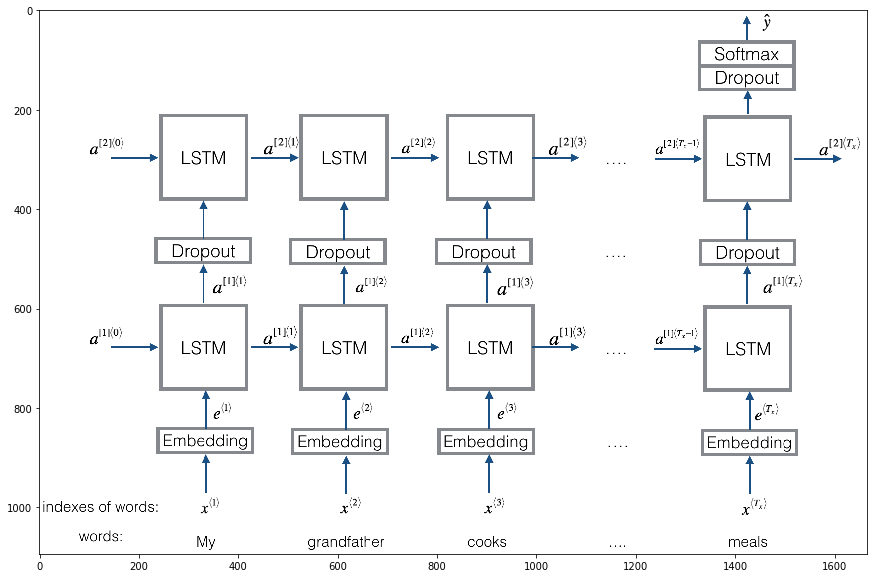

In [22]:
net1 = plt.imread("emojifier-v2.png")
plt.figure(figsize = (15, 10))
plt.imshow(net1)

In [0]:
def Emojifyv2(input_shape, word_to_vec_map, word_to_index):
    """
    Function to create a 128 (in this case) network graph. It's not compiled inside this function.
    
    Input: Input shape is usually (max_len,) and the mappings
    
    Output: a model instance in keras    
    """
    
    # Sentence_indices is the input of the graph
    # From now on I only create the network
    
    sentence_indices = Input(input_shape, dtype = "int32") # Layer, not a 
    
    # embedding layer
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index) # Function!!!!
    
    embeddings = embedding_layer(sentence_indices) # The function above returns a LAYER! this is why I don't do X = conv2d(...)(X)
    
    # "Normal" LSTM layers
    
    X = LSTM(128, return_sequences = True)(embeddings) # This is normal syntax
    
    X = Dropout(0.5)(X)
    
    # Second LSTM + dropout
    
    X = LSTM(128, return_sequences = False)(X)
    X = Dropout(0.5)(X)
    
    # Dense with 5 neurons, for the softmax
    
    X = Dense(5)(X)
    X = Activation("softmax")(X)
    
    model = Model(inputs = sentence_indices, outputs = X)
    
    return model
    
    

In [27]:
max_len = 10

the_model = Emojifyv2((max_len,), word_to_vec_map, word_to_index)

the_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645 

In [0]:
plot_model(the_model, to_file = "LSTM_net.png", show_shapes = True)

This seems correct. Let's compile to see if the model works.

In [31]:
optim = optimizers.Adam(lr = 1e-3)

hist = History()

the_model.compile(loss = "categorical_crossentropy", optimizer = optim, metrics = ["accuracy"])

In [0]:
X_train_indices = sentences_to_indices(X_train, word_to_index, max_len)

Y_train_oh = convert_to_one_hot(y_train, C = 5)

In [0]:
num_epochs = 50
b_size = 32

the_model.fit(X_train_indices, Y_train_oh, epochs = num_epochs,batch_size = b_size, callbacks = [hist])

The model is very small, so it runs very quickly and the train accuracy should be close to 1. Beware of overfitting! However, let's check the test accuracy to see. And to plot the history.

In [36]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len)
Y_train_oh = convert_to_one_hot(y_test, C = 5)

loss, acc = the_model.evaluate(X_test_indices, Y_train_oh)

print("Test accuracy = ", acc)

56/56 [==============================] - 0s 4ms/step
Test accuracy =  0.8392857142857143


In [39]:
print(hist.history.keys())

dict_keys(['loss', 'acc'])


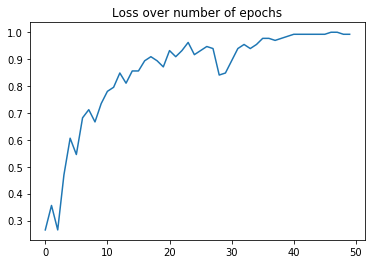

In [41]:
plt.figure();
plt.title("Loss over number of epochs")

plt.plot(range(num_epochs), list(hist.history.values())[1])

Not too bad, but this was not as interesting as I expected. Let's do something else.